In [187]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
from torch.optim import SGD

import numpy as np
from numpy import dot
import matplotlib.pyplot as plt

In [188]:
input_size = 784
hidden_size = 2048
num_classes = 10
num_epochs = 100
batch_size = 100
learning_rate = 0.1

S_G=20
M_train=2000

In [189]:
# MNIST dataset 
train_dataset = torchvision.datasets.MNIST(root='data', 
                                           train=True, 
                                           transform=transforms.ToTensor(), 
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='data', 
                                          train=False, 
                                          transform=transforms.ToTensor())


train_subset_index=list(range(M_train))

train_subset_dataset=Subset(train_dataset, train_subset_index)


# Data loader
train_loader = DataLoader(dataset=train_subset_dataset, batch_size=batch_size, shuffle=True)

test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

train_loader_1=DataLoader(dataset=train_subset_dataset, batch_size=1)

In [190]:
labels_to_investigate=[0,4,9]

In [191]:
import copy

labels_tofill=labels_to_investigate.copy()
labels_freq=[0 for k in range(len(labels_tofill))]
G_ind_tr=[]
for k,(image, label) in enumerate(train_loader_1):
    label=label.tolist()[0]
    if label in labels_tofill:
        ix=labels_to_investigate.index(label)
        G_ind_tr.append(k)
        labels_freq[ix]+=1
        if labels_freq[ix]==S_G:
            labels_tofill.remove(label)
    if len(labels_tofill)==0:
        break

labels_tofill=labels_to_investigate.copy()
labels_freq=[0 for k in range(len(labels_tofill))]
G_ind_ts=[]
for k,(image, label) in enumerate(train_loader_1):
    label=label.tolist()[0]
    if label in labels_tofill:
        ix=labels_to_investigate.index(label)
        G_ind_ts.append(k)
        labels_freq[ix]+=1
        if labels_freq[ix]==S_G:
            labels_tofill.remove(label)
    if len(labels_tofill)==0:
        break

G_subset_tr=Subset(train_dataset, G_ind_tr)
G_subset_ts=Subset(test_dataset, G_ind_ts)

G_loader_tr = DataLoader(dataset=G_subset_tr, batch_size=1, shuffle=False)
G_loader_ts = DataLoader(dataset=G_subset_ts, batch_size=1, shuffle=False)

In [192]:
# Fully connected neural network
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.input_layer = nn.Linear(input_size, hidden_size) 
        self.output_layer = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        x = self.input_layer(x)
        x = x.relu()
        x = self.output_layer(x)
        return x
    
def ReLU_glorot_init(model):
    for name, param in model.named_parameters():
        
        if name.endswith(".bias"):
            param.data.fill_(0)
        else:
            nn.init.xavier_normal_(param)

In [193]:
# Train the model

model = NeuralNet(input_size, hidden_size, num_classes)
ReLU_glorot_init(model)

init_grads_tr=[]
init_grads_ts=[]

criterion = nn.CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=learning_rate)


for image,label in G_loader_tr:
    image = image.reshape(-1, 28*28)
    output=model(image)
    loss = criterion(output,label)
    loss.backward()
    init_grad=[]
    init_grad+=torch.flatten(model.input_layer.weight.grad).tolist()
    init_grad+=model.input_layer.bias.grad.tolist()
    init_grad+=torch.flatten(model.output_layer.weight.grad).tolist()
    init_grad+=model.output_layer.bias.grad.tolist()
    init_grad=np.array(init_grad)
    init_grad=init_grad/np.linalg.norm(init_grad)
    init_grads_tr.append(init_grad)

for image,label in G_loader_ts:
    image = image.reshape(-1, 28*28)
    output=model(image)
    loss = criterion(output,label)
    loss.backward()
    init_grad=[]
    init_grad+=torch.flatten(model.input_layer.weight.grad).tolist()
    init_grad+=model.input_layer.bias.grad.tolist()
    init_grad+=torch.flatten(model.output_layer.weight.grad).tolist()
    init_grad+=model.output_layer.bias.grad.tolist()
    init_grad=np.array(init_grad)
    init_grad=init_grad/np.linalg.norm(init_grad)
    init_grads_ts.append(init_grad)

def train_epoch(GETGRADIENTS=False):
    for images, labels in train_loader:
        images = images.reshape(-1, 28*28)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    r_loss=loss.item()
    if GETGRADIENTS:
        dots_tr=[]
        for k,(image, label) in enumerate(G_loader_tr):
            image = image.reshape(-1, 28*28)
            output=model(image)
            loss = criterion(output,label)
            loss.backward()
            gradient=[]
            gradient+=torch.flatten(model.input_layer.weight.grad).tolist()
            gradient+=model.input_layer.bias.grad.tolist()
            gradient+=torch.flatten(model.output_layer.weight.grad).tolist()
            gradient+=model.output_layer.bias.grad.tolist()
            gradient=np.array(gradient)
            gradient=gradient/np.linalg.norm(gradient)
            dots_tr.append(np.dot(init_grads_tr[k],gradient))
        dots_ts=[]
        for k,(image, label) in enumerate(G_loader_ts):
            image = image.reshape(-1, 28*28)
            output=model(image)
            loss = criterion(output,label)
            loss.backward()
            gradient=[]
            gradient+=torch.flatten(model.input_layer.weight.grad).tolist()
            gradient+=model.input_layer.bias.grad.tolist()
            gradient+=torch.flatten(model.output_layer.weight.grad).tolist()
            gradient+=model.output_layer.bias.grad.tolist()
            gradient=np.array(gradient)
            gradient=gradient/np.linalg.norm(gradient)
            dots_ts.append(np.dot(init_grads_ts[k],gradient))

        return r_loss, dots_tr,dots_ts
    else:
        return loss.item()

train_loss = []
dots_tr = []
dots_ts = []
epoch_list=[]

for epoch in range(num_epochs):
    if (epoch+1)%5==0:
        trainloss, ds_tr,ds_ts = train_epoch(GETGRADIENTS=True)
        train_loss.append(trainloss)
        dots_tr.append(ds_tr)
        dots_ts.append(ds_ts)
        epoch_list.append(epoch+1)
    else:
        trainloss=train_epoch()
    print('Epoch: {} TrainLoss: {:.3f}'.format(epoch+1,trainloss))

Epoch: 1 TrainLoss: 0.855
Epoch: 2 TrainLoss: 0.618
Epoch: 3 TrainLoss: 0.548
Epoch: 4 TrainLoss: 0.501
Epoch: 5 TrainLoss: 0.384
Epoch: 6 TrainLoss: 0.356
Epoch: 7 TrainLoss: 0.336
Epoch: 8 TrainLoss: 0.257
Epoch: 9 TrainLoss: 0.399
Epoch: 10 TrainLoss: 0.230
Epoch: 11 TrainLoss: 0.218
Epoch: 12 TrainLoss: 0.265
Epoch: 13 TrainLoss: 0.250
Epoch: 14 TrainLoss: 0.151
Epoch: 15 TrainLoss: 0.156
Epoch: 16 TrainLoss: 0.225
Epoch: 17 TrainLoss: 0.314
Epoch: 18 TrainLoss: 0.281
Epoch: 19 TrainLoss: 0.206
Epoch: 20 TrainLoss: 0.171
Epoch: 21 TrainLoss: 0.178
Epoch: 22 TrainLoss: 0.134
Epoch: 23 TrainLoss: 0.153
Epoch: 24 TrainLoss: 0.119
Epoch: 25 TrainLoss: 0.108
Epoch: 26 TrainLoss: 0.072
Epoch: 27 TrainLoss: 0.143
Epoch: 28 TrainLoss: 0.114
Epoch: 29 TrainLoss: 0.104
Epoch: 30 TrainLoss: 0.117
Epoch: 31 TrainLoss: 0.083
Epoch: 32 TrainLoss: 0.155
Epoch: 33 TrainLoss: 0.080
Epoch: 34 TrainLoss: 0.074
Epoch: 35 TrainLoss: 0.192
Epoch: 36 TrainLoss: 0.065
Epoch: 37 TrainLoss: 0.066
Epoch: 38 

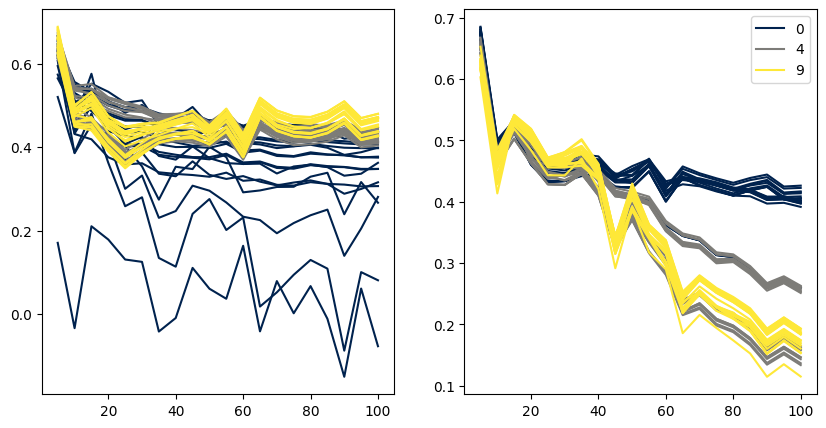

In [194]:
fig,axs=plt.subplots(1,2,figsize=(10,5))

N=len(epoch_list)

colors = plt.cm.cividis(np.linspace(0, 1, len(labels_to_investigate)))

for i in range(len(labels_to_investigate)):
    for j in range(S_G):
        if j==0:
            axs[0].plot(epoch_list,[dots_tr[n][i*S_G+j] for n in range(N)], c=colors[i],label=str(labels_to_investigate[i]))
            axs[1].plot(epoch_list,[dots_ts[n][i*S_G+j] for n in range(N)], c=colors[i],label=str(labels_to_investigate[i]))
        else:
            axs[0].plot(epoch_list,[dots_tr[n][i*S_G+j] for n in range(N)], c=colors[i])
            axs[1].plot(epoch_list,[dots_ts[n][i*S_G+j] for n in range(N)], c=colors[i])
plt.legend()

In [201]:
grad_matrix=[]
for image,label in G_loader_ts:
        image = image.reshape(-1, 28*28)
        output=model(image)
        loss = criterion(output,label)
        loss.backward()
        gradient=[]
        gradient+=torch.flatten(model.input_layer.weight.grad).tolist()
        gradient+=model.input_layer.bias.grad.tolist()
        gradient+=torch.flatten(model.output_layer.weight.grad).tolist()
        gradient+=model.output_layer.bias.grad.tolist()
        gradient=np.array(gradient)
        gradient=gradient/np.linalg.norm(gradient)
        grad_matrix.append(gradient)

ker_matrix=[]
for vec1 in grad_matrix:
    row=[]
    for vec2 in grad_matrix:
          row.append(np.dot(vec1,vec2))
    ker_matrix.append(row)

evals,evectors=np.linalg.eig(ker_matrix)

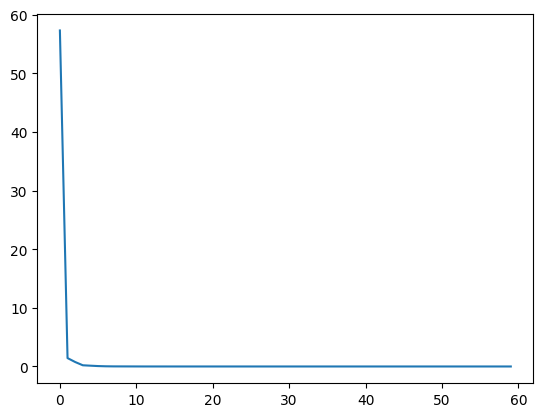

In [202]:
plt.plot(np.arange(len(evals)),evals)

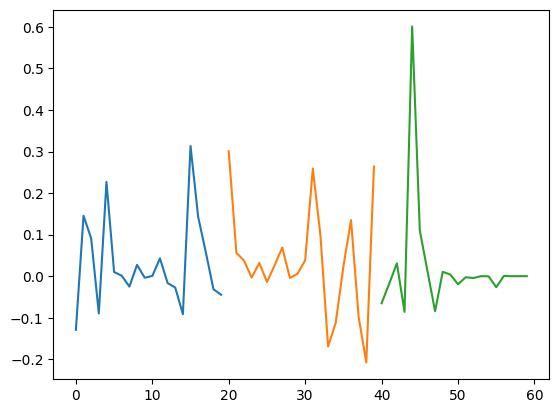

In [203]:
for k,evec in enumerate(evectors):
    if k==1:
        plt.plot(np.arange(0,S_G),evec[0:S_G])
        plt.plot(np.arange(S_G,2*S_G),evec[S_G:2*S_G])
        plt.plot(np.arange(2*S_G,3*S_G),evec[2*S_G:3*S_G])